In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d53d563f-0129-6980-0759-6ec4915c74ba)


In [2]:
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [3]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

unzip_data("nlp_getting_started.zip")

--2022-05-29 03:49:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-05-29 03:49:54 (129 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df_shuffled = train_df.sample(frac = 1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
len(train_df), len(test_df)

(7613, 3263)

In [9]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _,text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("-----\n")
  


Target: 0 (not real disaster)
Text:
why is it trouble@niallhariss / @simply_vain live on http://t.co/iAhJj0agq6

-----

Target: 0 (not real disaster)
Text:
Just added some more fire to the flames for Saturday! Rick Wonder will be spinning a guest set along with Chachi... http://t.co/Otblb9PJ2I

-----

Target: 0 (not real disaster)
Text:
4 Common Running Injuries and How to Avoid Them http://t.co/E5cNS6ufPA

-----

Target: 0 (not real disaster)
Text:
IM GONNA GET NAKED AND SMOKE MY CIGARETTE someone call me radneck or is it just too hot in here

-----

Target: 0 (not real disaster)
Text:
@holymileyray @moonIighthunty Focus on Me is going to obliterate careers tea

-----



In [10]:
train_df_shuffled["text"].to_numpy()

array(['So you have a new weapon that can cause un-imaginable destruction.',
       'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
       'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
       ...,
       'Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x',
       'Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY',
       'I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7'],
      dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size = 0.1,
    random_state = 42
)

In [12]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [14]:
val_sentences[:10]

array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
       'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
       'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
       '@camilacabello97 Internally and externally screaming',
       'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
       'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
       'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
       "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern C

In [15]:
train_labels[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length = None
                                    )

In [17]:
sum = 0
for i in train_sentences:
  sum+=len(i.split())

round(sum/len(train_sentences))

15

In [18]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [19]:
text_vectorizer.adapt(train_sentences)

In [20]:
sample_sentence = "There is a flood in my city"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 182,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
len(text_vectorizer.get_vocabulary())

10000

In [22]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")


Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [23]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             embeddings_initializer = "uniform",
                             input_length = max_length,
                             name = "embedding_1")
embedding

In [24]:
randsent = random.choice(train_sentences)
print(f"Original text:\n{randsent}\nEmbedded Version:")

sample_embed = embedding(text_vectorizer([randsent]))
sample_embed

Original text:
4 kidnapped ladies rescued by police in Enugu | Nigerian Tribune http://t.co/xYyEV89WIz
Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04893592,  0.0305549 , -0.00395172, ..., -0.00042392,
         -0.02374576, -0.01814268],
        [-0.01065068,  0.02654744, -0.02831559, ..., -0.00493678,
          0.01562527, -0.03699633],
        [-0.00642717, -0.02752748,  0.01566794, ...,  0.01571747,
          0.03132248, -0.01033671],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

In [25]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04893592,  0.0305549 , -0.00395172,  0.00321443, -0.01584117,
        0.00152613, -0.0392585 ,  0.01678619, -0.03558344,  0.00726699,
       -0.00621049, -0.02300065, -0.01088274, -0.04283394, -0.01865995,
       -0.00124991, -0.04147331,  0.01445608,  0.04982618, -0.02969872,
        0.01318598,  0.01107619, -0.04926417, -0.01956399, -0.0289367 ,
       -0.01600761, -0.00046401,  0.01986155, -0.03062608,  0.00856242,
       -0.04962444, -0.01361672, -0.04449151,  0.02804879,  0.00841118,
        0.0106616 ,  0.00387635, -0.02219143,  0.00588549,  0.03289751,
        0.00315518, -0.01360632, -0.04212229, -0.04411502, -0.00510212,
       -0.04334313, -0.00039537, -0.0201493 , -0.00813274, -0.03364245,
       -0.04622608,  0.03827603, -0.03190373, -0.0050171 , -0.03686937,
       -0.00502889, -0.03279513,  0.00878844, -0.03084737, -0.00133021,
       -0.00368226,  0.00758331, -0.00983058, -0.00485982, -0.01203017,
       -0.018472

In [26]:
""" Model 0: Naive Bayes (baseline)
    Model 1: Feed-forward neural network (dense model)
    Model 2: LSTM model
    Model 3: GRU model
    Model 4: Bidirectional-LSTM model
    Model 5: 1D Convolutional Neural Network
    Model 6: TensorFlow Hub Pretrained Feature Extractor
    Model 7: Same as model 6 with 10% of training data """

' Model 0: Naive Bayes (baseline)\n    Model 1: Feed-forward neural network (dense model)\n    Model 2: LSTM model\n    Model 3: GRU model\n    Model 4: Bidirectional-LSTM model\n    Model 5: 1D Convolutional Neural Network\n    Model 6: TensorFlow Hub Pretrained Feature Extractor\n    Model 7: Same as model 6 with 10% of training data '

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score*100


79.26509186351706

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)*100
  model_precision, model_recall, model_f1, k = precision_recall_fscore_support(y_true, y_pred, average = "weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [30]:
baseline_preds = model_0.predict(val_sentences)

In [31]:
baseline_results = calculate_results(y_true = val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [32]:
SAVE_DIR = "model_logs"

inputs = tf.keras.layers.Input(shape = (1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [33]:
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [35]:
model_1_history  = model_1.fit(train_sentences,
                               train_labels,
                               epochs = 5,
                               validation_data = (val_sentences, val_labels),
                               callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                        experiment_name = "simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20220529-035000
Epoch 1/5
215/215 [==============================] - 9s 9ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [36]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [37]:
(embedding.weights)

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073165,  0.015048  , -0.03425456, ..., -0.0440354 ,
         -0.01042282,  0.01876437],
        [ 0.04135865, -0.03945084, -0.0381194 , ...,  0.00464736,
          0.03163552,  0.029283  ],
        [ 0.00684031,  0.05363132, -0.00241556, ..., -0.07082175,
         -0.04750704,  0.01448253],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018393,  0.03510419],
        [-0.03723461,  0.06267187, -0.07451147, ..., -0.02367217,
         -0.0864333 ,  0.01742156]], dtype=float32)>]

In [38]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights)

[[ 0.00073165  0.015048   -0.03425456 ... -0.0440354  -0.01042282
   0.01876437]
 [ 0.04135865 -0.03945084 -0.0381194  ...  0.00464736  0.03163552
   0.029283  ]
 [ 0.00684031  0.05363132 -0.00241556 ... -0.07082175 -0.04750704
   0.01448253]
 ...
 [-0.03301444 -0.0052493  -0.04209725 ...  0.02028764  0.00308807
   0.02215792]
 [ 0.00692343  0.05942352 -0.01975194 ... -0.06199061 -0.01018393
   0.03510419]
 [-0.03723461  0.06267187 -0.07451147 ... -0.02367217 -0.0864333
   0.01742156]]


In [39]:
model_1_pred_probs = model_1.predict(val_sentences)
len(model_1_pred_probs)

762

In [40]:
model_1_pred_probs[:10]

array([[0.4048821 ],
       [0.74433124],
       [0.997895  ],
       [0.10889999],
       [0.11143532],
       [0.93556094],
       [0.91345936],
       [0.9925345 ],
       [0.97156817],
       [0.2657034 ]], dtype=float32)

In [41]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [42]:
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)

model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7846966492209201,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497}

In [43]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [44]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [46]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


## LSTM

In [47]:
max_vocab_length, max_length

(10000, 15)

In [48]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = "uniform",
                                     input_length = max_length,
                                     name = "embedding_2")

inputs = layers.Input(shape = (1,), dtype='string')
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")

(None, 15, 128)
(None, 64)


In [49]:
model_2.compile(loss = "binary_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ["accuracy"])

In [50]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [51]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20220529-035024
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [52]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape , model_2_pred_probs[:10]

((762, 1), array([[0.007126  ],
        [0.7873678 ],
        [0.9996376 ],
        [0.05679173],
        [0.0025822 ],
        [0.9996238 ],
        [0.92170197],
        [0.9997993 ],
        [0.9994954 ],
        [0.66457385]], dtype=float32))

In [53]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [54]:
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'f1': 0.7489268622514025,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026}

In [55]:

compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


##GRU

In [56]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim = max_vocab_length,
                                     output_dim = 128,
                                     embeddings_initializer = "uniform",
                                     input_length = max_length,
                                     name = "embedding_3")

inputs = layers.Input(shape = (1,), dtype = "string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


In [57]:
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [58]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20220529-035037
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [59]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape , model_3_pred_probs[:10]

((762, 1), array([[0.33325273],
        [0.87741184],
        [0.9980252 ],
        [0.11561756],
        [0.01235959],
        [0.9925639 ],
        [0.62142634],
        [0.99813336],
        [0.9982377 ],
        [0.5018107 ]], dtype=float32))

In [60]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
model_3_results = calculate_results(y_true = val_labels,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7667932666650168,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708}

In [62]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [63]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [89]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20220529-043045
Epoch 1/5
215/215 [==============================] - 9s 16ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [90]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.04000053],
       [0.8279291 ],
       [0.99842227],
       [0.13531098],
       [0.00311338],
       [0.99220747],
       [0.95528346],
       [0.99945647],
       [0.99898285],
       [0.2814169 ]], dtype=float32)

In [66]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters = 32, kernel_size=5, activation = "relu")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [67]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02534915, -0.03109059,  0.00285616, ..., -0.0078316 ,
          -0.02685575, -0.04434131],
         [-0.06586259,  0.09451495, -0.01477602, ..., -0.00657781,
          -0.04238793,  0.07777894],
         [-0.04803652, -0.00709757, -0.02330895, ..., -0.01807331,
           0.02351034,  0.02676384],
         ...,
         [ 0.00073165,  0.015048  , -0.03425456, ..., -0.0440354 ,
          -0.01042282,  0.01876437],
         [ 0.00073165,  0.015048  , -0.03425456, ..., -0.0440354 ,
          -0.01042282,  0.01876437],
         [ 0.00073165,  0.015048  , -0.03425456, ..., -0.0440354 ,
          -0.01042282,  0.01876437]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08324983, 0.00648716, 0.        , 0.03983573, 0.        ,
          0.01144416, 0.00416252, 0.02288392, 0.        , 0.0090098 ,
          0.        , 0.        , 0.03401771, 0.06408273, 0.08103722,
          0.00409015, 0.

In [68]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [69]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20220529-035054
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [70]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.22534494],
       [0.7534112 ],
       [0.9995602 ],
       [0.0556279 ],
       [0.01449848],
       [0.9858518 ],
       [0.98418933],
       [0.99758804],
       [0.99862623],
       [0.2691439 ]], dtype=float32)

In [71]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [72]:
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'f1': 0.7758810170952618,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129}

In [73]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"When you call the universal sentence) encoder on a sentence, it turns it into numbers."])
embed_samples[0], len(embed_samples)

(<tf.Tensor: shape=(512,), dtype=float32, numpy=
 array([-0.02820581, -0.01780899,  0.05088179, -0.01620845,  0.01474094,
         0.06452333,  0.01582767,  0.0456593 ,  0.02280888, -0.01727332,
         0.03267067, -0.01284321,  0.0606361 ,  0.08656505,  0.07898349,
        -0.05591469,  0.03466977, -0.04050618,  0.02368309, -0.05897749,
        -0.0217113 ,  0.03696577,  0.04038666,  0.02966448,  0.00531368,
        -0.05822133, -0.0314095 ,  0.0108068 , -0.04406692, -0.03811276,
         0.00012601,  0.03756585,  0.00396881, -0.00471088, -0.01966425,
        -0.08377109,  0.02430249,  0.02060695, -0.00735478, -0.05516516,
        -0.01139396,  0.00391332, -0.04604854,  0.06096118, -0.10904785,
        -0.02488614, -0.03093143, -0.02995981,  0.01174946,  0.01477875,
         0.01001648, -0.10525183, -0.08471715,  0.04655132, -0.03784806,
         0.0385983 ,  0.03496175, -0.03006053, -0.05873662,  0.02853621,
        -0.04874968, -0.0340079 ,  0.01197663, -0.02327158,  0.02883152,
  

In [75]:
sentence_encode_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape = [],
                                       dtype = tf.string,
                                       trainable = False,
                                       name = "USE")

In [76]:
model_6 = tf.keras.Sequential([
                               sentence_encode_layer,
                               layers.Dense(64, activation = "relu"),
                               layers.Dense(1, activation = "sigmoid")
], name = "model_6_USE")

model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [77]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220529-042110
Epoch 1/5
215/215 [==============================] - 11s 31ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [78]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.14443195],
       [0.72715056],
       [0.9856655 ],
       [0.19740927],
       [0.7341703 ],
       [0.6859663 ],
       [0.9808888 ],
       [0.9741101 ],
       [0.9157322 ],
       [0.08070081]], dtype=float32)

In [79]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [80]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results


{'accuracy': 81.23359580052494,
 'f1': 0.810686575717776,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494}

In [91]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7651213533864446,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657}

In [93]:
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "simple_dense":model_1_results,
    "lstm": model_2_results,
    "gru": model_3_results,
    "bidirectional": model_4_results,
    "conv1d": model_5_results,
    "tf_hub_sentence_encoder": model_6_results
})
all_model_results

,baseline,simple_dense,lstm,gru,bidirectional,conv1d,tf_hub_sentence_encoder
accuracy,79.265092,78.740157,75.065617,76.771654,76.640420,77.821522,81.233596
precision,0.811139,0.791492,0.751008,0.767545,0.766590,0.780752,0.814880
recall,0.792651,0.787402,0.750656,0.767717,0.766404,0.778215,0.812336
f1,0.786219,0.784697,0.748927,0.766793,0.765121,0.775881,0.810687


In [94]:
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687


In [95]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

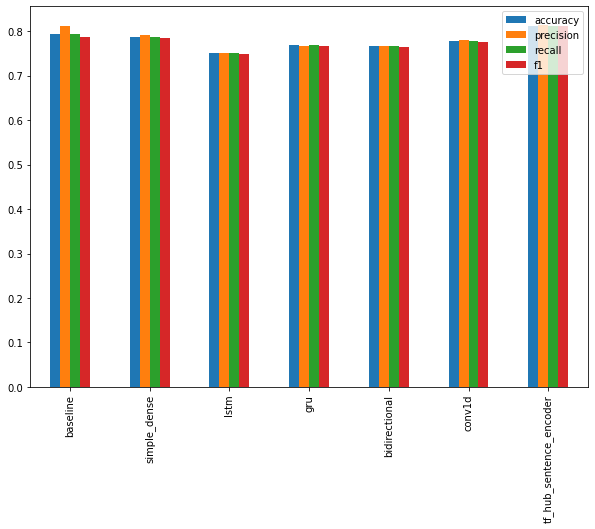

In [96]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7))

In [101]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [102]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'f1': 0.7805169025578647,
 'precision': 0.7805216999297674,
 'recall': 0.7808398950131233}

In [103]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [104]:
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [105]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.750656,0.751008,0.750656,0.748927
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
ensemble_results,0.780840,0.780522,0.780840,0.780517


In [106]:
model_6.save("model_6.h5")

### 0 = Not a real disaster Tweet
### 1 = Real disaster Tweet

In [108]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("\n")


Pred: 1, Prob: 0.98692387342453
Text:
A house was evacuated in Orakei after a bank collapsed and trees were felled by strong winds in Auckland ... http://t.co/UCuCmKypdN #NZ



Pred: 0, Prob: 0.14735418558120728
Text:
Stewart bought a new property earlier this year w/ the intention of providing a sanctuary for rescued farm animals. https://t.co/ExXtboah8h



Pred: 1, Prob: 0.968957245349884
Text:
70 Years After Atomic Bombs Japan Still Struggles With Wartime Past: The anniversary of the devastation wroug... http://t.co/AU6Sm5FaMq



Pred: 0, Prob: 0.08248341828584671
Text:
Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall!! http://t.co/UgXhHErrxS



Pred: 0, Prob: 0.29220178723335266
Text:
@imKanoMate [the stabbing did not really affect her but she did get stab wounds and was bleeding Skarlet then pushed him backwards +



Pred: 0, Prob: 0.11893278360366821
Text:
@AshleyDniece GM! I pray any attack of the enemy 2 derail ur destiny is blocked